In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import LucaM185
device = torch.device("cuda:0")


In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

When scaling the MLP for large sequences, the number of parameters grows rapidly. Modern LLMs like GPT-4 can handle up to 128,000 tokens (each token is typically 2-5 characters), indicating something is amiss. 

Our core issue is that the number of parameters depends on the input sequence length. To address this, we can design an very simple architecture, which maintains a hidden state and updates it with linear layers. By reusing the same layers repeatedly, we can scale the sequence length indefinitely. 

This approach processes embeddings with the same parameters for all time steps, avoiding the need for unique parameters at each step. (the positionality is learned by the model and progressively encoded in the hidden state)

Millions of parameters: 0.09
Epoch ___0 - Loss: 4.243
Epoch _300 - Loss: 2.749
Epoch _600 - Loss: 2.425
Epoch _900 - Loss: 2.233
Epoch 1200 - Loss: 2.162
Epoch 1500 - Loss: 2.084
Epoch 1800 - Loss: 2.087
Epoch 2100 - Loss: 1.971
Epoch 2400 - Loss: 2.169
Epoch 2700 - Loss: 1.857


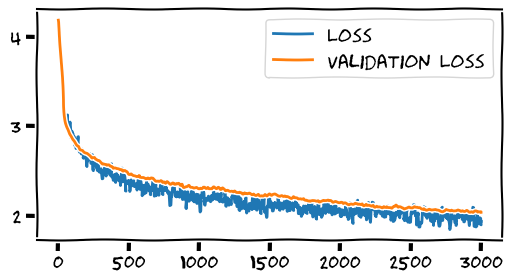

In [ ]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fcih = nn.Linear(emb_size, hidden_size)
        self.fchh = nn.Linear(hidden_size, hidden_size)
        self.fcho = nn.Linear(hidden_size, vocab_size) 
    
    def forward(self, inputs):
        emb = self.embeddings(inputs) # removed flatten, shape is (batch_size, sequence_length, emb_size)
        state = torch.zeros(inputs.shape[0], self.fchh.weight.shape[0]).to(device) # (batch_size, hidden_size)
        
        for elm in range(emb.shape[1]):
            state = torch.tanh(self.fcih(emb[:, elm]) + self.fchh(state))

        return self.fcho(state)

model = RNN(emb_size=32, hidden_size=256).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(6, 3))  
plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
plt.legend()

By calculating the loss at each time step, you're effectively turning a single sequence prediction into multiple label predictions, increasing the training signal. For the same computation, this gives you 20x the number of labels and updates, allowing the model to learn richer dependencies. This makes RNNs more efficient at handling long sequences by leveraging every step for learning.

In [ ]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, 1:] 
# going from predicting the last character to predicting the next character at every step
# Note the difference between sequences[2000:, 1:] and sequences[2000:, -1] in the previous cell
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, 1:]

Millions of parameters: 0.09
Epoch ___0 - Loss: 4.241
Epoch _300 - Loss: 2.336
Epoch _600 - Loss: 2.141
Epoch _900 - Loss: 1.977
Epoch 1200 - Loss: 1.925
Epoch 1500 - Loss: 1.881
Epoch 1800 - Loss: 1.889
Epoch 2100 - Loss: 1.861
Epoch 2400 - Loss: 1.776
Epoch 2700 - Loss: 1.793


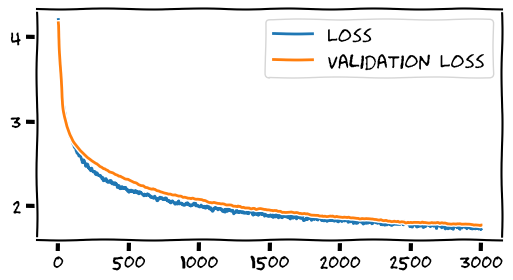

In [ ]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fcxh = nn.Linear(emb_size, hidden_size)
        self.fchh = nn.Linear(hidden_size, hidden_size)
        self.fcxy = nn.Linear(hidden_size, vocab_size) 

    def forward(self, inputs):
        emb = self.embeddings(inputs) # removed flatten, shape is (batch_size, sequence_length, emb_size)
        state = torch.zeros(inputs.shape[0], self.fchh.weight.shape[0]).to(device) # (batch_size, hidden_size)
        
        out = []
        for elm in range(emb.shape[1]):
            state = torch.tanh(self.fcxh(emb[:, elm]) + self.fchh(state))
            out.append(self.fcxy(state))
            
        return torch.stack(out[:], dim=1) # (batch_size, sequence_length, hidden_size) 


model = RNN(emb_size=32, hidden_size=256).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred.reshape(-1, vocab_size), val_labels.to(device).reshape(-1))
        vlossi.append(vloss.item())

from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(6, 3))  
plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
plt.legend()

In [ ]:
sequence_lengths = [1, 2, 4, 8, 16, 32, 64, 128, 256]
losses = []
vlosses = []

for sequence_length in sequence_lengths:
    texttoint = {elm: n for n, elm in enumerate(set(load))}
    inttotext = {n:elm for n, elm in enumerate(set(load))}
    dataset = [texttoint[c] for c in load]

    vocab_size = len(texttoint)

    sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
    inputs = sequences[2000:, :-1]
    labels = sequences[2000:, 1:] 
    # going from predicting the last character to predicting the next character at every step
    # Note the difference between sequences[2000:, 1:] and sequences[2000:, -1] in the previous cell
    val_inputs = sequences[:2000, :-1]
    val_labels = sequences[:2000, 1:]

    model = RNN(emb_size=32, hidden_size=256).to(device)

    epochs = 3000
    batch_size = 128
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

    lossi = []
    vlossi = []

    for epoch in range(epochs):
        indexes = torch.randint(0, len(inputs), (batch_size,))
        
        pred = model(inputs[indexes].to(device)) 
        loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lossi.append(loss.item())
        
        with torch.no_grad():
            pred = model(val_inputs.to(device))
            vloss = F.cross_entropy(pred.reshape(-1, vocab_size), val_labels.to(device).reshape(-1))
            vlossi.append(vloss.item())

    print(f"Processed sequence length: {sequence_length:_>3d}, loss: {sum(lossi[-100:])/100:.3f}, validation loss: {sum(vlossi[-100:])/100:.3f}")
    losses.append(lossi)
    vlosses.append(vlossi)


Processed sequence length: __1, loss: 2.496, validation loss: 2.604
Processed sequence length: __2, loss: 2.323, validation loss: 2.400
Processed sequence length: __4, loss: 2.128, validation loss: 2.189
Processed sequence length: __8, loss: 1.936, validation loss: 1.985
Processed sequence length: _16, loss: 1.786, validation loss: 1.819
Processed sequence length: _32, loss: 1.683, validation loss: 1.698
Processed sequence length: _64, loss: 1.604, validation loss: 1.628
Processed sequence length: 128, loss: 1.547, validation loss: 1.558
Processed sequence length: 256, loss: 1.510, validation loss: 1.529


We get severly limited return on out increase of sequence length. So we can try to optimize our architecture to make it better

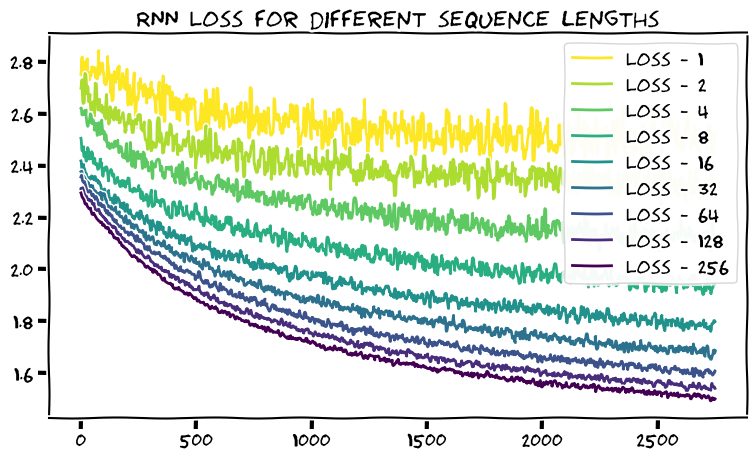

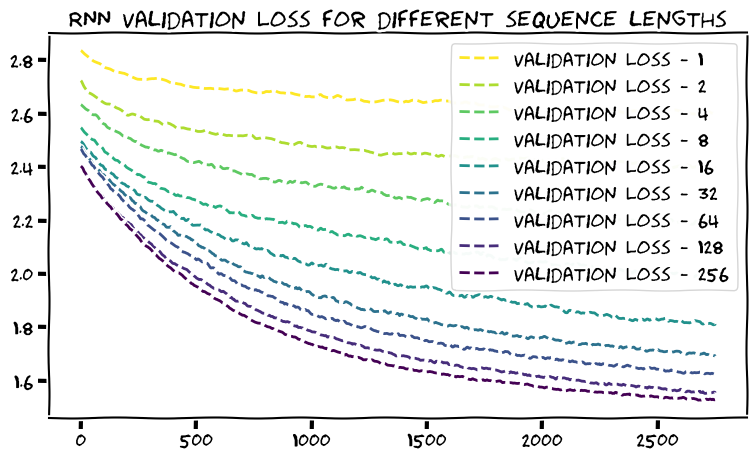

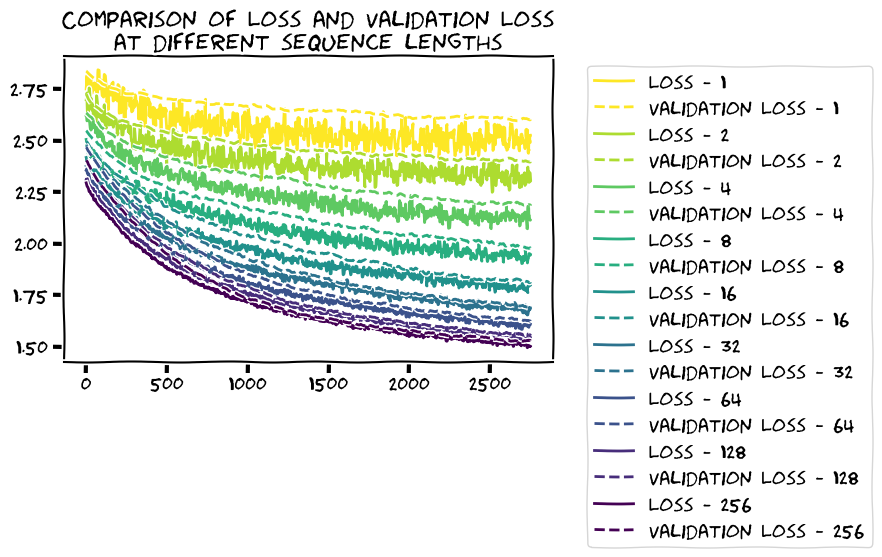

In [8]:
import numpy as np

plt.figure(figsize=(9, 5))
colors = plt.cm.viridis(np.linspace(1, 0, len(sequence_lengths)))

for loss, vloss, sequence_length, color in zip(losses, vlosses, sequence_lengths, colors):
    plt.plot(gaussian_filter1d(loss[250:], sigma=2), label=f"Loss - {sequence_length}", color=color)

plt.title("RNN Loss for different sequence lengths")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(9, 5))
for loss, vloss, sequence_length, color in zip(losses, vlosses, sequence_lengths, colors):
    plt.plot(gaussian_filter1d(vloss[250:], sigma=2), label=f"Validation Loss - {sequence_length}", linestyle='--', color=color)

plt.title("RNN Validation Loss for different sequence lengths")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(9, 5))
for loss, vloss, sequence_length, color in zip(losses, vlosses, sequence_lengths, colors):
    plt.plot(gaussian_filter1d(loss[250:], sigma=2), label=f"Loss - {sequence_length}", color=color)
    plt.plot(gaussian_filter1d(vloss[250:], sigma=2), label=f"Validation Loss - {sequence_length}", linestyle='--', color=color)

plt.title("Comparison of Loss and Validation Loss\nat different sequence lengths")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# LSTM
The key difference between an RNN and an LSTM lies in their handling of the hidden state. An RNN updates the hidden state using a simple activation function, which can struggle with long-term dependencies due to vanishing gradients. In contrast, an LSTM introduces a more complex cell state and gates (input, forget, and output), allowing it to better retain and regulate information over long sequences, improving its ability to capture long-term dependencies.

In practice this implementation will perform on par with an RNN with the same low sequence length. If you want to see a performance gap between the two, you should experiment with longer sequences and possibly with a more interesting dataset. 

In [ ]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)

sequence_length = 50
sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, 1:] 
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, 1:]


Millions of parameters: 0.32
Epoch ___0 - Loss: 4.175
Epoch _300 - Loss: 2.415
Epoch _600 - Loss: 2.111
Epoch _900 - Loss: 1.966
Epoch 1200 - Loss: 1.858
Epoch 1500 - Loss: 1.814
Epoch 1800 - Loss: 1.701
Epoch 2100 - Loss: 1.685
Epoch 2400 - Loss: 1.653
Epoch 2700 - Loss: 1.614


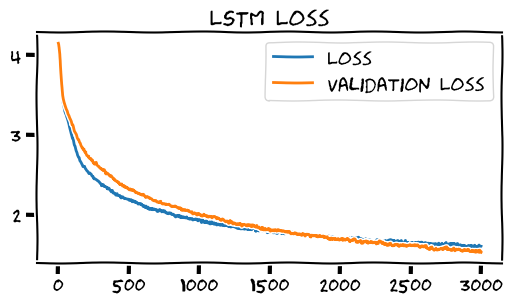

In [ ]:

class LSTM(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.ui = nn.Linear(emb_size, hidden_size)
        self.uf = nn.Linear(emb_size, hidden_size)
        self.uo = nn.Linear(emb_size, hidden_size)
        self.ug = nn.Linear(emb_size, hidden_size)
        self.wi = nn.Linear(hidden_size, hidden_size)
        self.wf = nn.Linear(hidden_size, hidden_size)
        self.wo = nn.Linear(hidden_size, hidden_size)
        self.wg = nn.Linear(hidden_size, hidden_size)
        self.fcxy = nn.Linear(hidden_size, vocab_size)  # Add output layer

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        state = torch.zeros(inputs.shape[0], self.wf.out_features).to(device)
        cell = torch.zeros(inputs.shape[0], self.wf.out_features).to(device)
        states = torch.zeros(inputs.shape[0], inputs.shape[1], self.wf.out_features).to(device)

        out = []
        for elm in range(emb.shape[1]):
            i = torch.sigmoid(self.ui(emb[:, elm]) + self.wi(state))
            f = torch.sigmoid(self.uf(emb[:, elm]) + self.wf(state))
            o = torch.sigmoid(self.uo(emb[:, elm]) + self.wo(state))
            g = torch.tanh(self.ug(emb[:, elm]) + self.wg(state))
            cell = f * cell + i * g
            state = o * torch.tanh(cell)
            states[:, elm] = state
            out.append(self.fcxy(state))

        return torch.stack(out[:], dim=1)
        
    
model = LSTM(emb_size=32, hidden_size=256).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred.view(-1, 65), labels[indexes].view(-1).to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs)//4, (batch_size,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred.view(-1, 65), val_labels[indexes].view(-1).to(device))
        vlossi.append(vloss.item())

from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(6, 3))  
plt.title("LSTM Loss")
plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
plt.legend()

# Sequential is slow
RNNs and LSTMs are inharently sequential in nature, they process one input token at a time. 
CPUs have compute units extremely optimized to run sequential calculations as fast as possible, but there is a limit dictated by physics, and to get around it we usually build many compute units that can work in parallel. 

Note: to go fast, CPUs try to find parallelism in supposedly sequential instructions and try to run them at the same time to maximise performance (see branch prediction/speculative execution). This workload instead is inharently sequential in nature so even CPUs are inadequate. 

GPUs have thousands of processors working in parallel connected to lots of memory at very high bandwidth. This is why we often prefer to do more calculations in parallel than less in series, it's just faster because of the nature of the hardware. 
In particular, Linear layers with big batch sizes are very fast. 